<a href="https://colab.research.google.com/github/apallath/generative_art/blob/main/deep_dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep dream generation using Inception v3 trained on ImageNet

References:
- Chollet's Deep Learning with Python 1e
- Keras tutorial
- Tensorflow tutorial
- Google's [Deep Dream notebook](https://github.com/google/deepdream/blob/master/dream.ipynb)

In [1]:
# Mount Google Drive
import os, shutil
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import inception_v3

In [3]:
class InceptionV3DeepDreamer():
    def __init__(self, layer_weights: dict, num_octaves=3, octave_scale=1.4, 
                 num_iter=3, step_size=0.02, tv=True, log=True):
        self.layer_weights = layer_weights

        model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
        outputs_dict = dict(
            [(layer.name, layer.output) for layer in [model.get_layer(name) for name in self.layer_weights.keys()]]
        )
        self.feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

        self.num_octaves = num_octaves
        self.octave_scale = octave_scale
        self.num_iter = num_iter
        self.step_size = step_size
        self.tv = tv
        self.log = log
        
    def load_image(self, image_path, resize_height=None, resize_width=None):
        """Loads image from path and resizes it to (resize_height, resize_width).
        If width or height are None, resizes while keeping the aspect ratio the same
        as the original image."""
        img = image.load_img(image_path)
        img = image.img_to_array(img)

        if resize_width is not None and resize_height is None:
            original_shape = img.shape[1:3]
            img = tf.image.resize(img, [int(resize_width / original_shape[1] * x) for x in original_shape])

        elif resize_width is None and resize_height is not None:
            original_shape = img.shape[:2]
            img = tf.image.resize(img, [int(resize_height / original_shape[0] * x) for x in original_shape])

        elif resize_width is not None and resize_height is not None:
            img = tf.image.resize(img, [resize_height, resize_width])

        return img

    def preprocess_image(self, img):
        """
        Preprocess image for InceptionV3
        """
        img = img[np.newaxis, ...]
        img = inception_v3.preprocess_input(img)
        return img

    def deprocess_image(self, img):
        """
        Deprocess dreamed image from InceptionV3
        """
        img = img.reshape((img.shape[1], img.shape[2], 3))
        # Undo Inception v3 preprocessing
        img /= 2
        img += 0.5
        img *= 255.0
        # Convert to uint8 and clip to the valid range [0, 255]
        img = np.clip(img, 0, 255).astype("uint8")
        return img

    def dream_loss(self, img):
        features = self.feature_extractor(img)

        # Weighted sum of normalized activations
        losses = []

        for name in features.keys():
            weight = self.layer_weights[name]
            activation = features[name]
            losses.append(weight * tf.math.reduce_mean(activation))
            
        loss = tf.reduce_sum(losses)

        if self.tv:
            loss += tf.image.total_variation(activation)

        return loss

    @tf.function
    def gradient_ascent_step(self, img):
        loss = tf.constant(0.0)

        with tf.GradientTape() as tape:
            tape.watch(img)
            loss = self.dream_loss(img)

        # Compute gradients
        grads = tape.gradient(loss, img)
        # Normalize gradients
        grads /= tf.math.reduce_std(grads) + 1e-8 
        # Step
        img += self.step_size * grads
        img = tf.clip_by_value(img, -1, 1)

        return loss, img

    def gradient_ascent_loop(self, img):
        for i in range(self.num_iter):
            loss, img = self.gradient_ascent_step(img)
            if self.log:
                print("Iter: {}, Loss: {}".format(i, loss))
        return img

    def __call__(self, image, preprocess=True, deprocess=True):
        if preprocess:
            original_img = self.preprocess_image(image)
        else:
            original_img = image

        # Constuct a list of output shapes after each octave, in reverse
        original_shape = original_img.shape[1:3]

        output_shapes = [original_shape]

        for i in range(1, self.num_octaves):
            shape = tuple([int(dim / (self.octave_scale ** i)) for dim in original_shape])
            output_shapes.append(shape)
            
        output_shapes = output_shapes[::-1]

        # Shrink original image to input octave shape
        shrunk_original_img = tf.image.resize(original_img, output_shapes[0])

        # Make a copy of original image to dream on
        img = tf.identity(original_img)

        for i, shape in enumerate(output_shapes):
            if self.log:
                print("Octave {}: Output shape: {}".format(i, shape))

            img = tf.image.resize(img, shape)

            # Perform gradient ascent on dream image
            img = self.gradient_ascent_loop(img)

            # Compute lost detail in original image (upscaled shrunk - downscaled)
            upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
            downscaled_original_img = tf.image.resize(original_img, shape)
            lost_detail = downscaled_original_img - upscaled_shrunk_original_img

            # Inject lost detail
            img += lost_detail

            # Update
            shrunk_original_img = tf.image.resize(original_img, shape)

        if deprocess:
            img = self.deprocess_image(img.numpy())

        return img

Iter 0
Iter 1
Iter 2
Iter 3
Iter 4


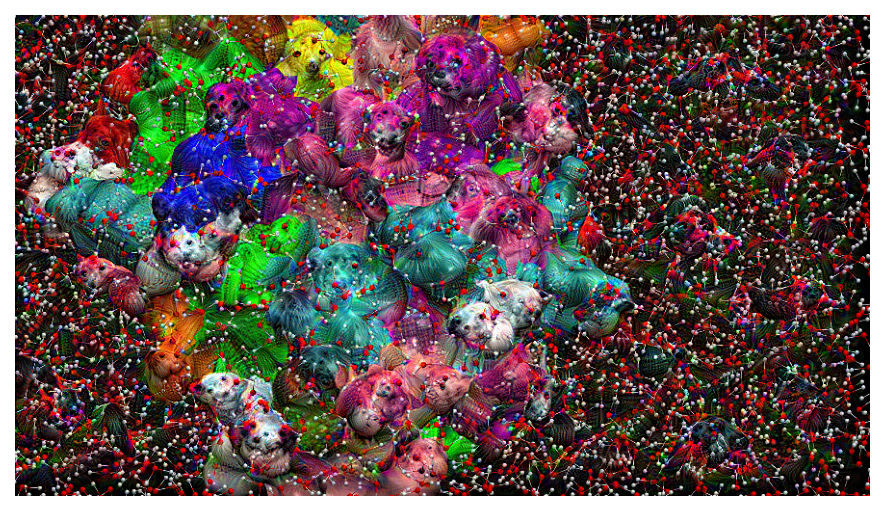

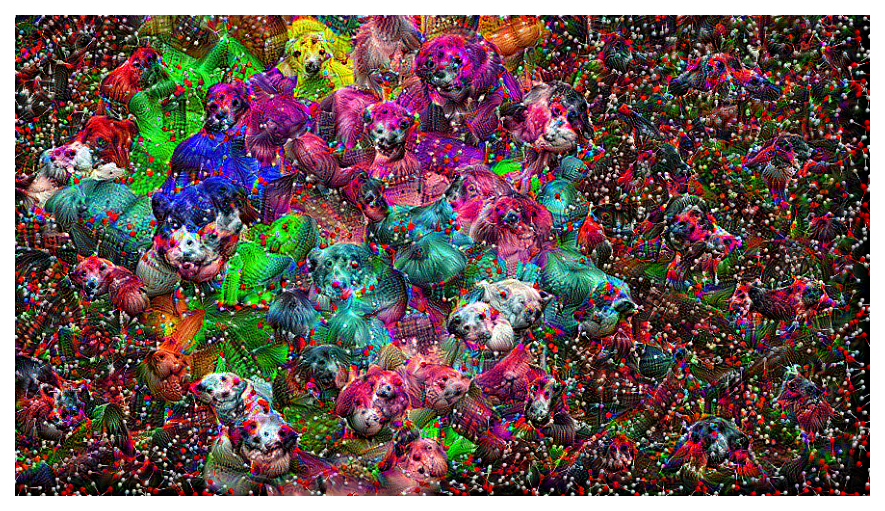

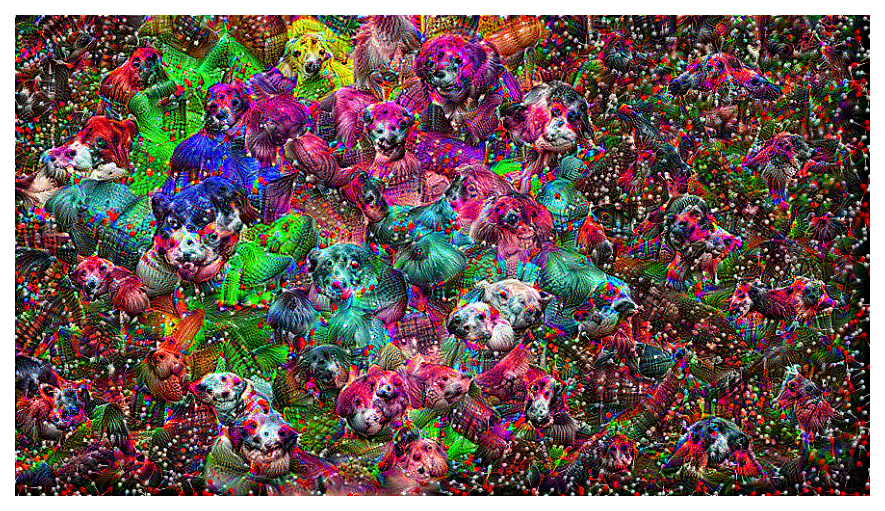

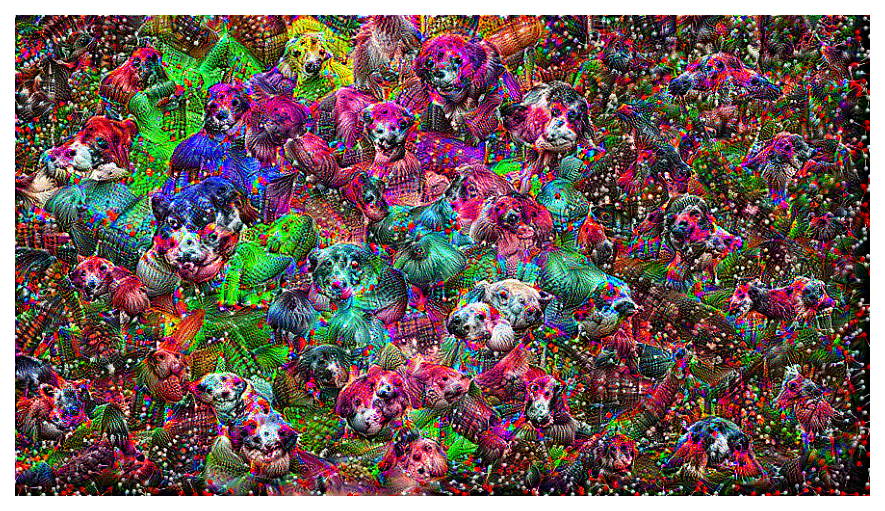

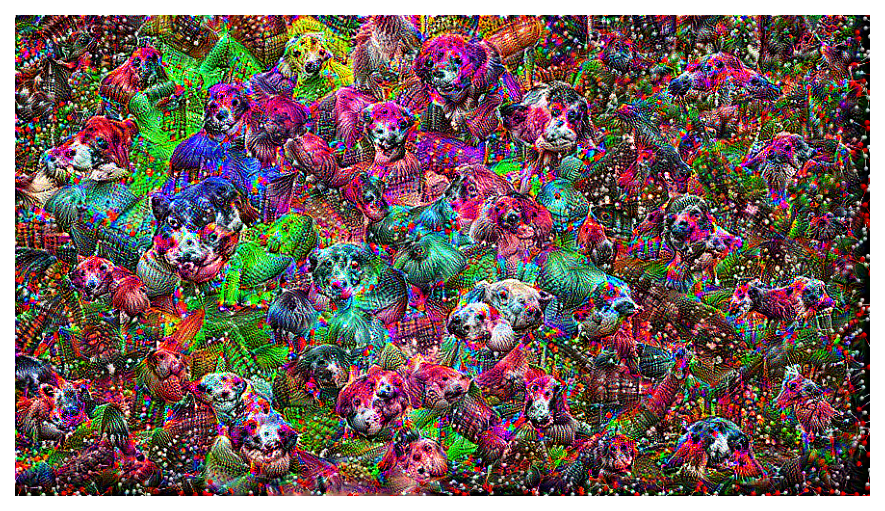

In [11]:
plt.close('all')

layer_weights = {
    "mixed4": 2.5,
    "mixed5": 0.8
    }
dream_params = {
    'num_octaves': 3, 
    'octave_scale': 1.4, 
    'num_iter': 100,
    'step_size': 0.01, 
    'tv': True,
    'log': False
    }
dreamer = InceptionV3DeepDreamer(layer_weights=layer_weights, **dream_params)

base_image_path = "/content/drive/MyDrive/colab_data/solvated_ubq.jpg"
img = dreamer.load_image(base_image_path, resize_height=500)

for i in range(5):
    print("Iter {}".format(i))
    img = dreamer(img)
    out_image_path = "/content/drive/MyDrive/colab_data/solvated_ubq_dream_iter{}.jpg".format(i)
    keras.preprocessing.image.save_img(out_image_path, img)

    plt.figure(dpi=150)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()